Analysis of data scraped

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import warnings
import mysql.connector

warnings.filterwarnings('ignore')

In [37]:
mysql_password = os.environ.get("MYSQL_PASSWORD")
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password=mysql_password
)
mycursor = mydb.cursor(dictionary=True)

mycursor.execute("USE webscraper;")

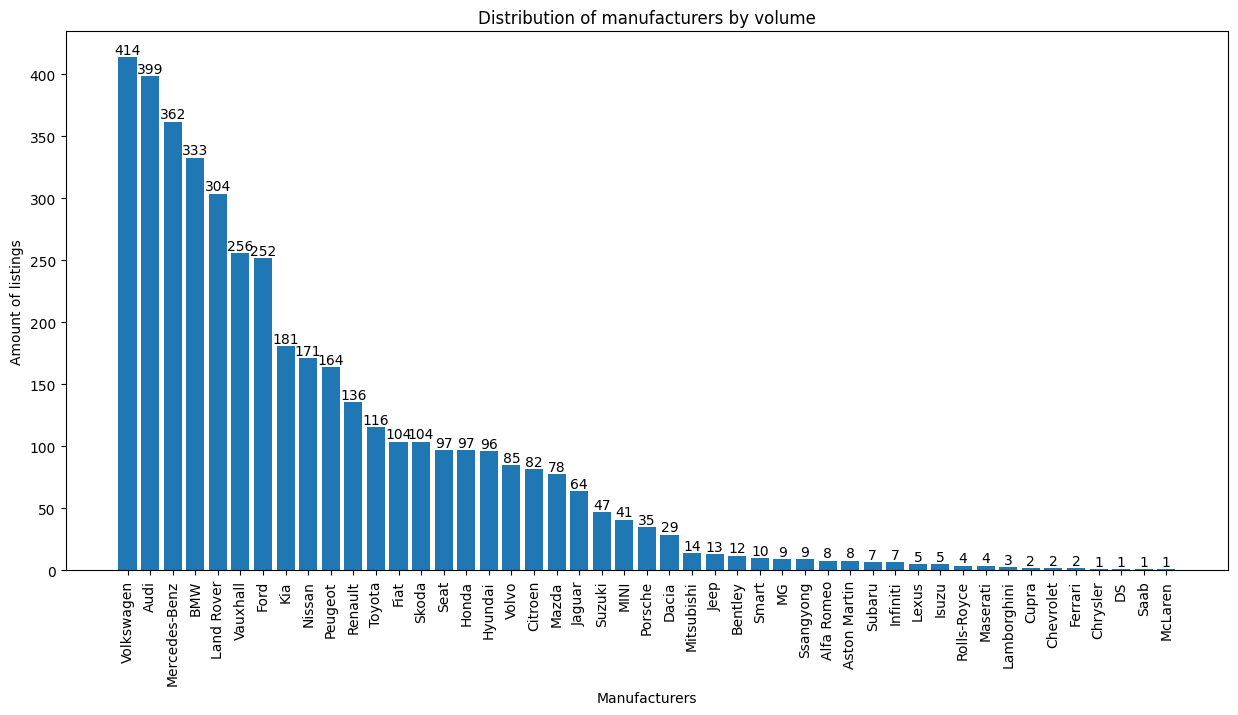

In [38]:
manufacturer_bar_data = []
# finding the amount of each manufacturer from the database
my_query = """
SELECT manufacturer_name, COUNT(*) as count
FROM (
    SELECT dataset.manufacturer_id, manufacturers.manufacturer_name
    FROM dataset
    LEFT JOIN manufacturers ON dataset.manufacturer_id = manufacturers.manufacturer_id
) AS joined_data
GROUP BY manufacturer_name
ORDER BY count DESC;
"""
mycursor.execute(my_query)
results = mycursor.fetchall()
for row in results:
    manufacturer_bar_data.append(row)

# splitting the manufacturer_ids from their respective counts
manufacturer_names = np.array([entry['manufacturer_name'] for entry in manufacturer_bar_data])
counts = np.array([entry['count'] for entry in manufacturer_bar_data])

# plotting the bar chart
plt.figure(figsize=(15,7))
bars = plt.bar(manufacturer_names, counts)
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(count), ha='center', va='bottom')
plt.title("Distribution of manufacturers by volume")
plt.xlabel("Manufacturers"), plt.ylabel("Amount of listings"), plt.xticks(rotation=90)
plt.show()

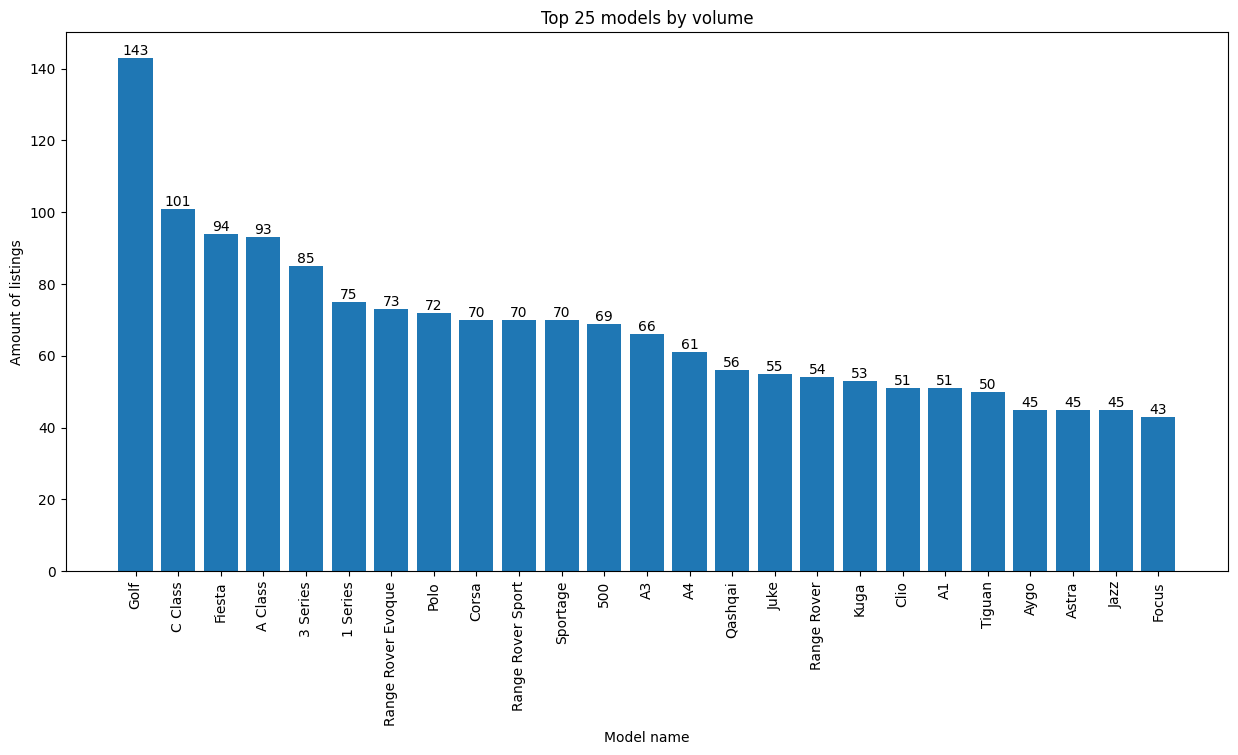

In [39]:
model_bar_data = []
# finding the top 25 models by amount from the database
my_query = """
SELECT model_name, COUNT(*) as count
FROM (
    SELECT dataset.model_id, models.model_name
    FROM dataset
    LEFT JOIN models ON dataset.model_id = models.model_id
) AS joined_data
GROUP BY model_name
ORDER BY count DESC
LIMIT 25;
"""
mycursor.execute(my_query)
results = mycursor.fetchall()
for row in results:
    model_bar_data.append(row)

# splitting the model_id from their respective counts
model_names = np.array([entry['model_name'] for entry in model_bar_data])
counts = np.array([entry['count'] for entry in model_bar_data])

# plotting the bar chart
plt.figure(figsize=(15,7))
bars = plt.bar(model_names, counts)
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(count), ha='center', va='bottom')
plt.title("Top 25 models by volume")
plt.xlabel("Model name"), plt.ylabel("Amount of listings")
plt.xticks(rotation=90)
plt.show() 

In [40]:
# distribution of fuel types for each manufacturer
fuel_type_query = """
SELECT m.manufacturer_name, f.fuel_type, 
       count(*) as occurrences
       FROM webscraper.dataset d
			INNER JOIN manufacturers m ON m.manufacturer_id = d.manufacturer_id
			INNER JOIN fuel_types f ON f.fuel_id = d.fuel_type_id
group by d.manufacturer_id, fuel_type_id
order by manufacturer_name ASC, fuel_type ASC;
"""

mycursor.execute(fuel_type_query)
results = mycursor.fetchall()

# using the pd.read_sql function we can get queries directly into dataframes
result_dataframe = pd.read_sql(fuel_type_query, mydb)
#print(result_dataframe)


manufacturer_fuel_data = {}
for manufacturer in manufacturer_names:
    manufacturer_fuel_data[manufacturer] = {}    
for entry in results:
    manufacturer = entry['manufacturer_name']
    fuel_type = entry['fuel_type']
    occurrences = entry['occurrences']

    if fuel_type not in manufacturer_fuel_data[manufacturer]:
        manufacturer_fuel_data[manufacturer][fuel_type] = occurrences
    else:
        manufacturer_fuel_data[manufacturer][fuel_type] += occurrences
    
df = pd.DataFrame.from_dict(manufacturer_fuel_data, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'manufacturer'}, inplace=True)
df.fillna(0, inplace=True)

my_manufacturer_list = []
my_diesel_list = []
my_hybrid_list = []
my_petrol_list = []

# ax = df.plot(x='manufacturer', kind='bar', figsize=(15, 7), stacked=True, rot=90)
# ax.set_xlabel('Manufacturers')
# ax.set_ylabel('Occurrences')


# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate(f'{int(height)}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, weight='bold')
#     
# plt.show()

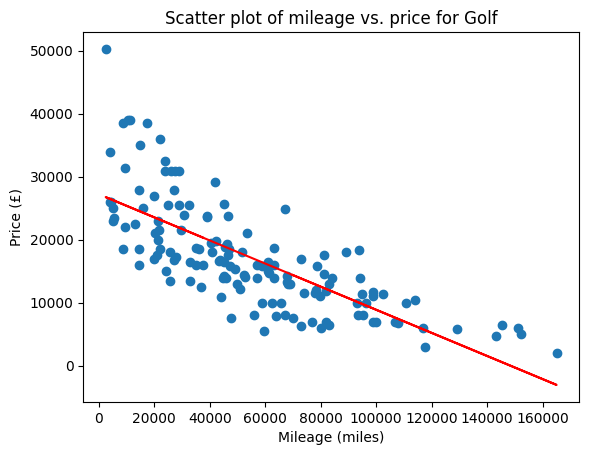

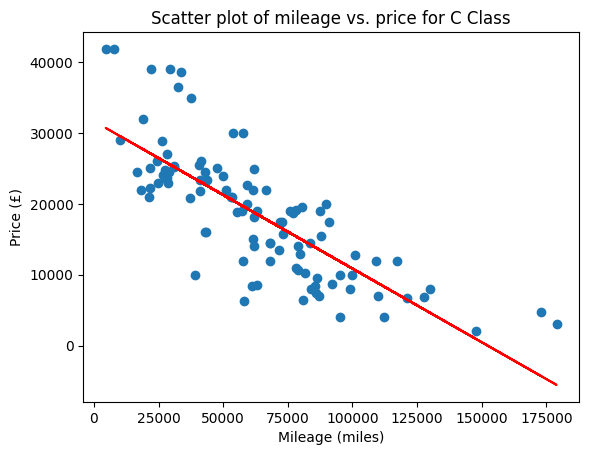

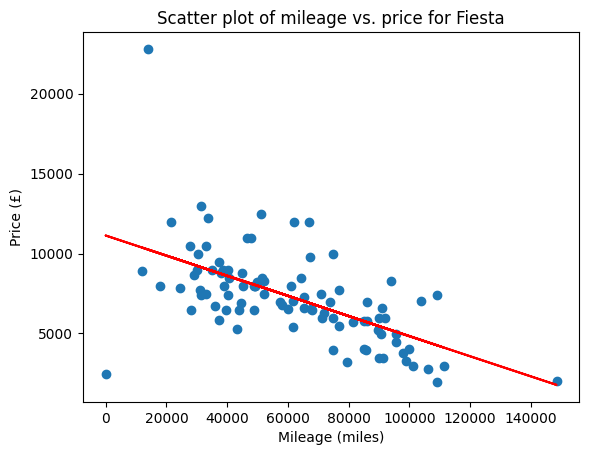

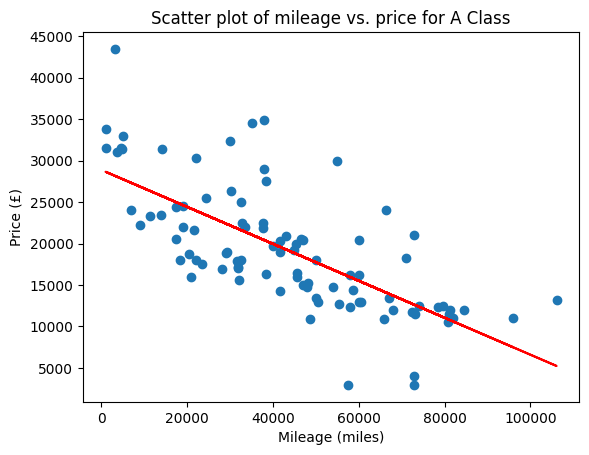

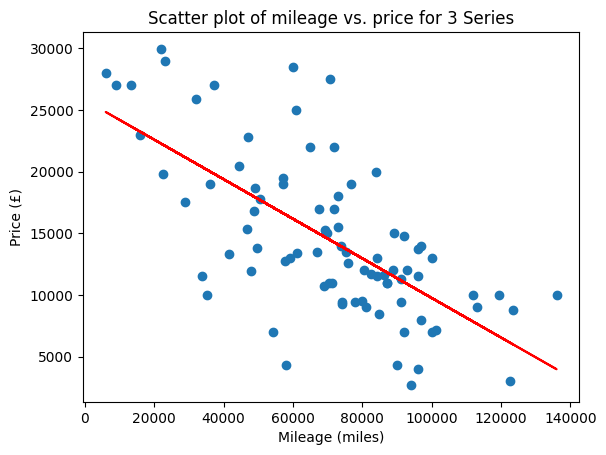

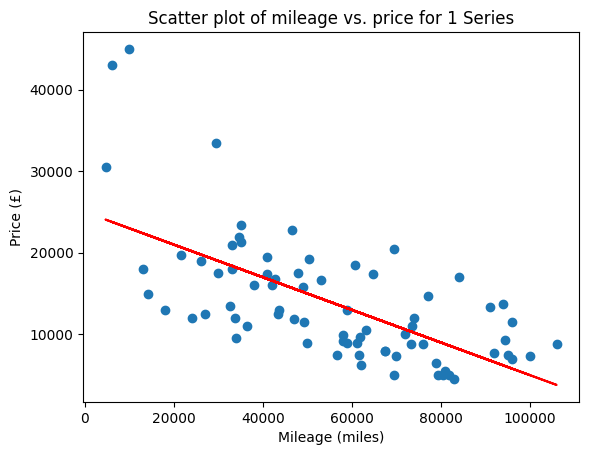

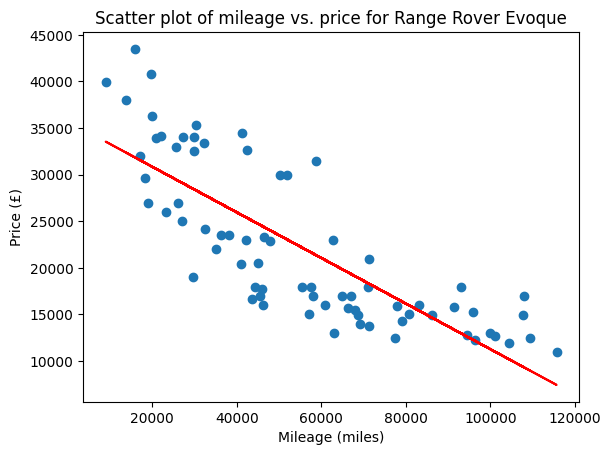

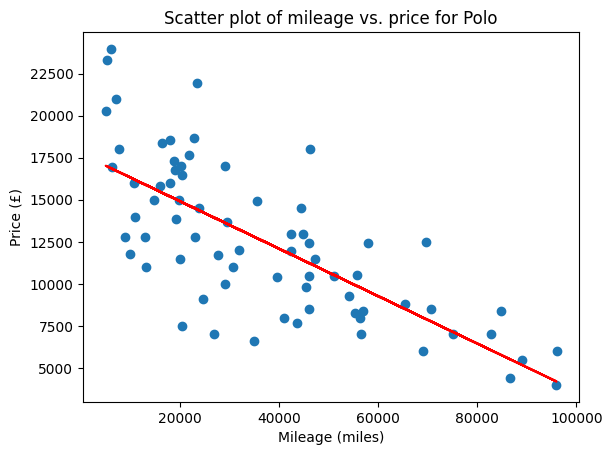

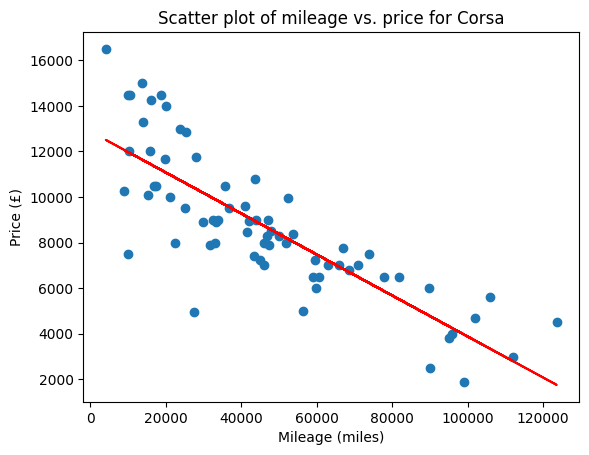

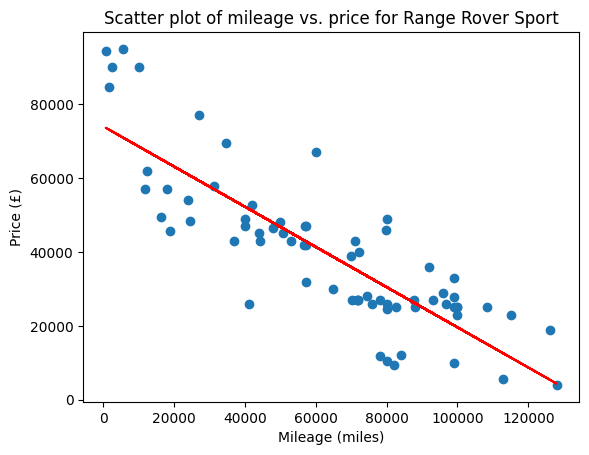

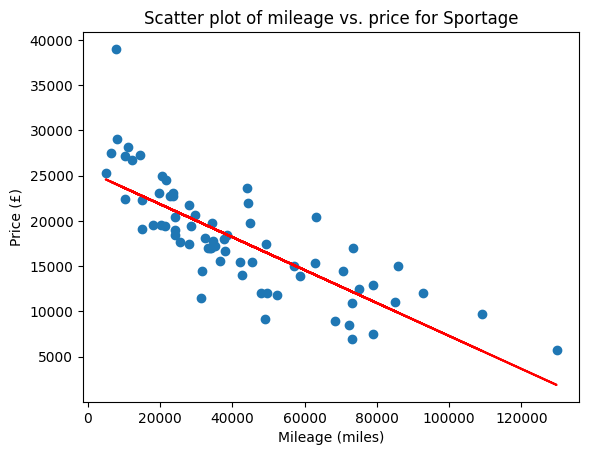

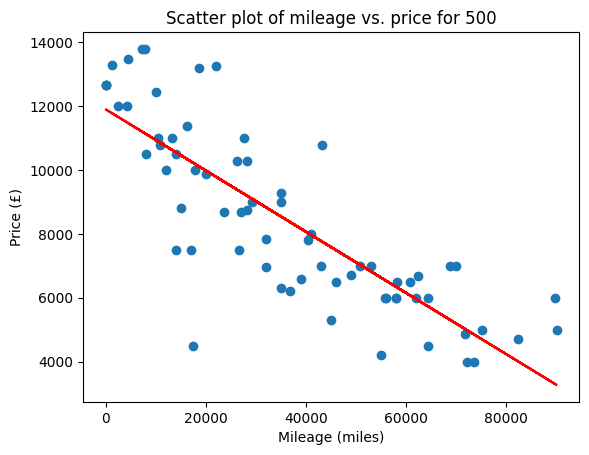

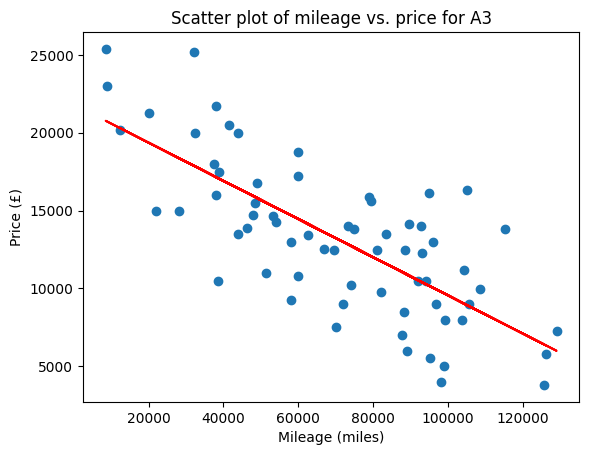

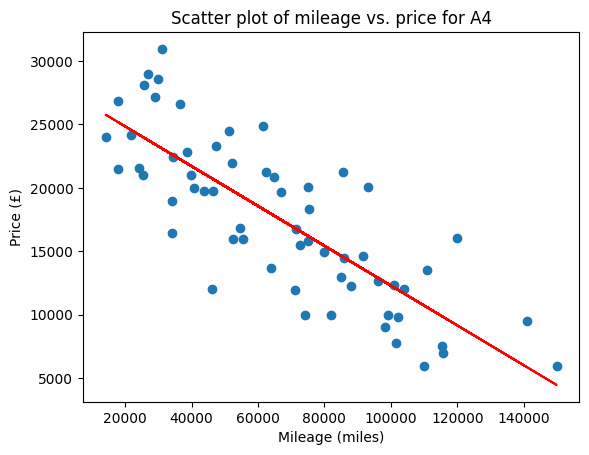

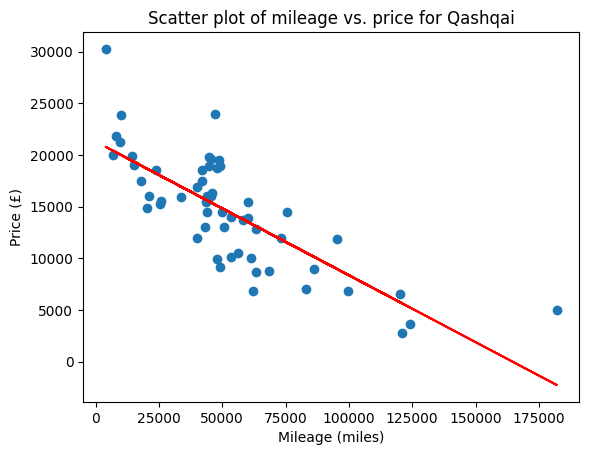

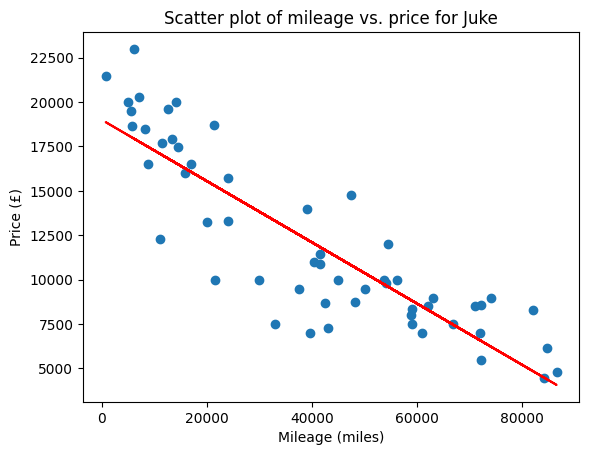

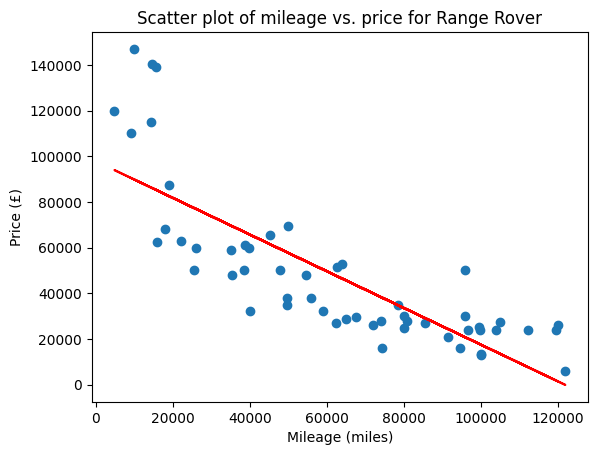

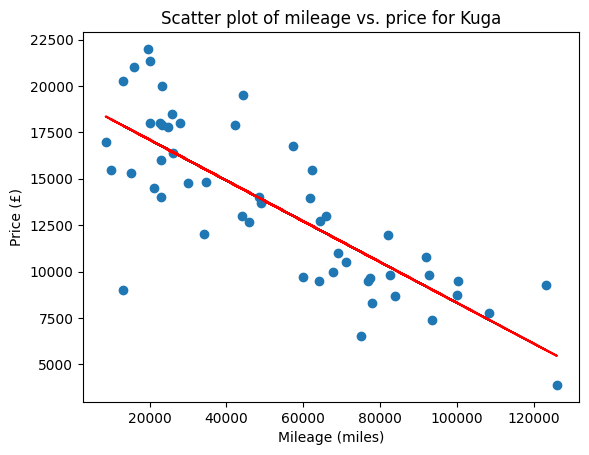

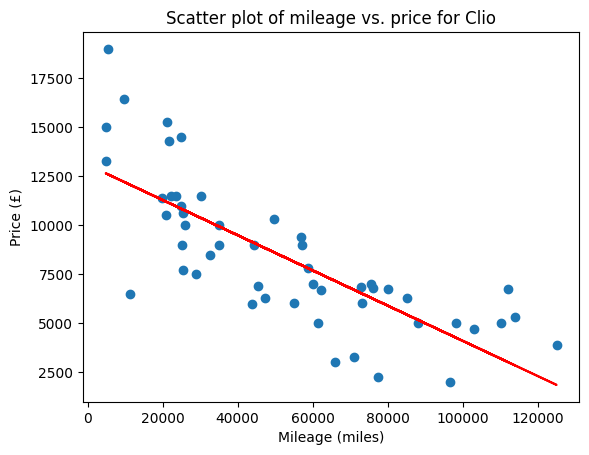

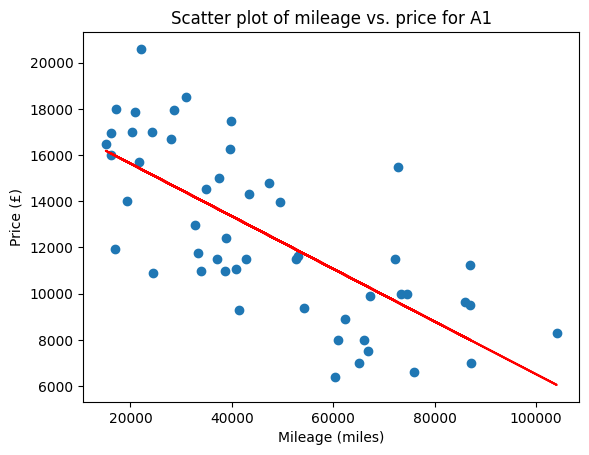

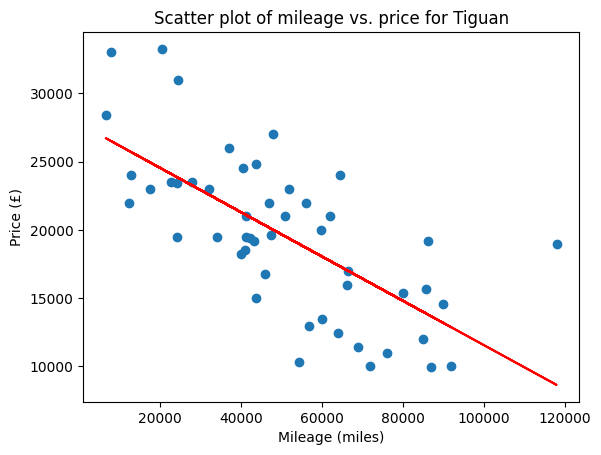

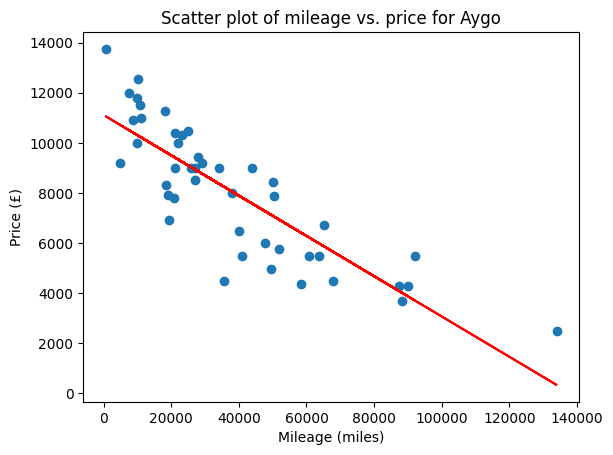

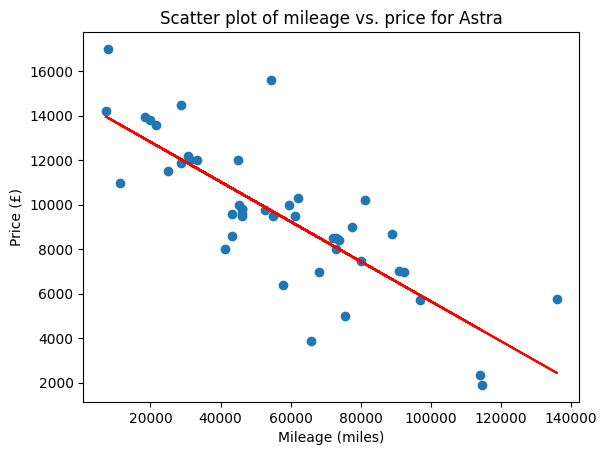

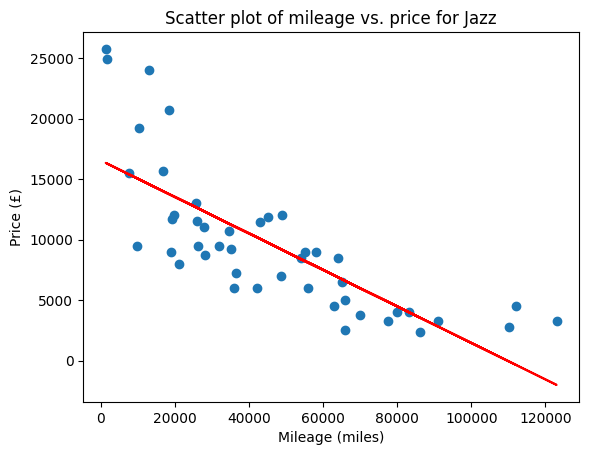

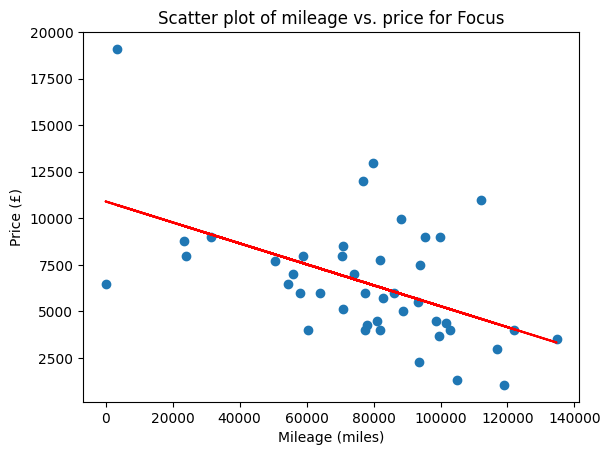

          manufacturer      rate
0          Range Rover -0.802923
1    Range Rover Sport -0.543727
2   Range Rover Evoque -0.244671
3              A Class -0.222771
4              C Class -0.207774
5             1 Series -0.199995
6                 Golf -0.183437
7             Sportage -0.181957
8                 Juke -0.172514
9               Tiguan -0.162248
10            3 Series -0.160467
11                  A4 -0.156852
12                Jazz -0.150698
13                Polo -0.140959
14             Qashqai -0.129379
15                  A3 -0.122747
16                  A1 -0.113983
17                Kuga -0.109811
18                 500 -0.095887
19                Clio -0.089982
20               Corsa -0.089947
21               Astra -0.089426
22                Aygo -0.080415
23              Fiesta -0.062880
24               Focus -0.056270


In [41]:
# scatter plots and rate analysis for the top 25 models:

query = "SELECT model_id, COUNT(*) as count FROM dataset GROUP BY model_id ORDER BY count DESC LIMIT 25"
results = pd.read_sql(query, mydb)
models = list(results['model_id'])

rates = []

for i in range(len(models)):
    query = f"SELECT * FROM dataset WHERE model_id = {models[i]}"
    results = pd.read_sql(query, mydb)
    
    x = results['Mileage (miles)']
    y = results['price']
    
    coefficients = np.polyfit(x, y, 1)
    
    plt.scatter(x, y)
    plt.title(f"Scatter plot of mileage vs. price for {model_bar_data[i]['model_name']}")
    plt.xlabel("Mileage (miles)"), plt.ylabel("Price (£)")
    
    x_array = np.array(x)
    
    plt.plot(x, coefficients[0] * x_array + coefficients[1], color='r')
    
    plt.show()

    rate = (coefficients[0])
    rates.append(rate)


# dataframe of ascending rates of depreciation with mileage
rates_data = {'manufacturer': [entry['model_name'] for entry in model_bar_data], 'rate': rates}
rates_dataframe = pd.DataFrame(rates_data)
rates_dataframe = rates_dataframe.sort_values(by='rate', ascending=True)
rates_dataframe.reset_index(drop=True, inplace=True)
print(rates_dataframe)

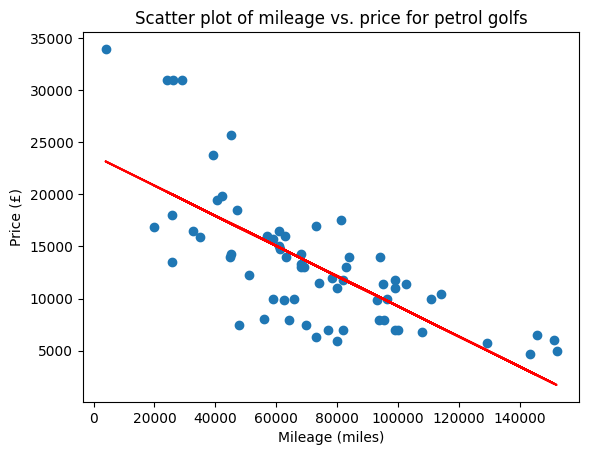

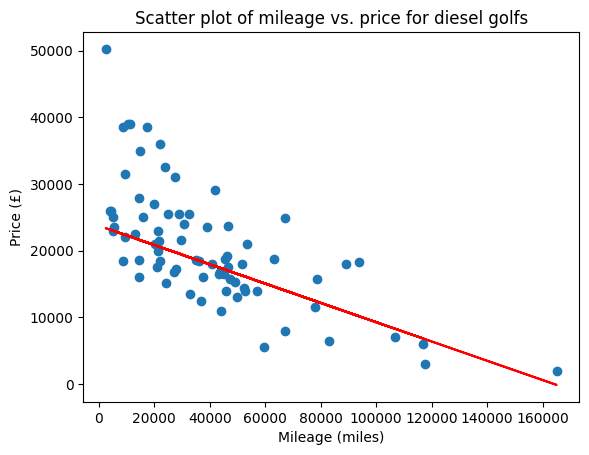

In [42]:
# analysis of vw golf petrol v diesel

query = "SELECT * FROM dataset WHERE model_id = 5 AND fuel_type_id = 2"
results = pd.read_sql(query, mydb)

x = results['Mileage (miles)']
y = results['price']

coefficients = np.polyfit(x, y, 1)

plt.scatter(x, y)
plt.title("Scatter plot of mileage vs. price for petrol golfs")
plt.xlabel("Mileage (miles)"), plt.ylabel("Price (£)")

x_array = np.array(x)

plt.plot(x, coefficients[0] * x_array + coefficients[1], color='r')

plt.show()

query = "SELECT * FROM dataset WHERE model_id = 5 AND fuel_type_id = 1"
results = pd.read_sql(query, mydb)

x = results['Mileage (miles)']
y = results ['price']

plt.scatter(x, y)
plt.title("Scatter plot of mileage vs. price for diesel golfs")
plt.xlabel("Mileage (miles)"), plt.ylabel("Price (£)")

x_array = np.array(x)

plt.plot(x, coefficients[0] * x_array + coefficients[1], color='r')

plt.show()

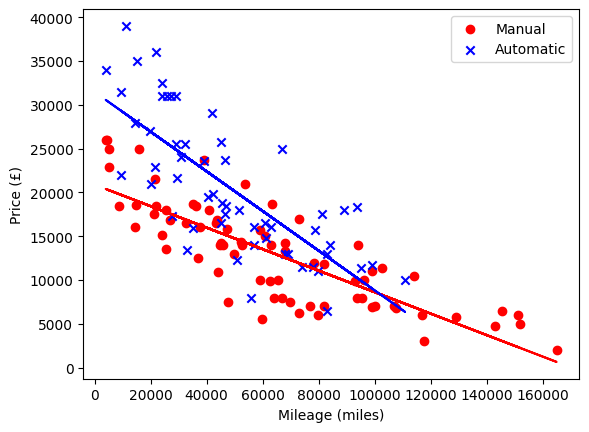

In [59]:
# manual golfs
query = "SELECT * FROM dataset WHERE model_id = 5 and transmission_type_id = 2"
results_set1 = pd.read_sql(query, mydb)

x_set1 = results_set1['Mileage (miles)']
y_set1 = results_set1['price']

query = "SELECT * FROM dataset WHERE model_id = 5 and transmission_type_id = 3"
results_set2 = pd.read_sql(query, mydb)

x_set2 = results_set2['Mileage (miles)']
y_set2 = results_set2['price']

fig, ax = plt.subplots()

ax.scatter(x_set1, y_set1, label='Manual', color='red', marker='o')

ax.scatter(x_set2, y_set2, label='Automatic', color='blue', marker='x')

coefficients_set1 = np.polyfit(x_set1, y_set1, 1)

x_set1_array = np.array(x_set1)

ax.plot(x_set1, coefficients_set1[0] * x_set1_array + coefficients_set1[1], color='r')

coefficients_set2 = np.polyfit(x_set2, y_set2, 1)

x_set2_array = np.array(x_set2)

ax.plot(x_set2, coefficients_set2[0] * x_set2_array + coefficients_set2[1], color='b')

ax.set_xlabel("Mileage (miles)"), ax.set_ylabel("Price (£)")
ax.legend()

plt.show()

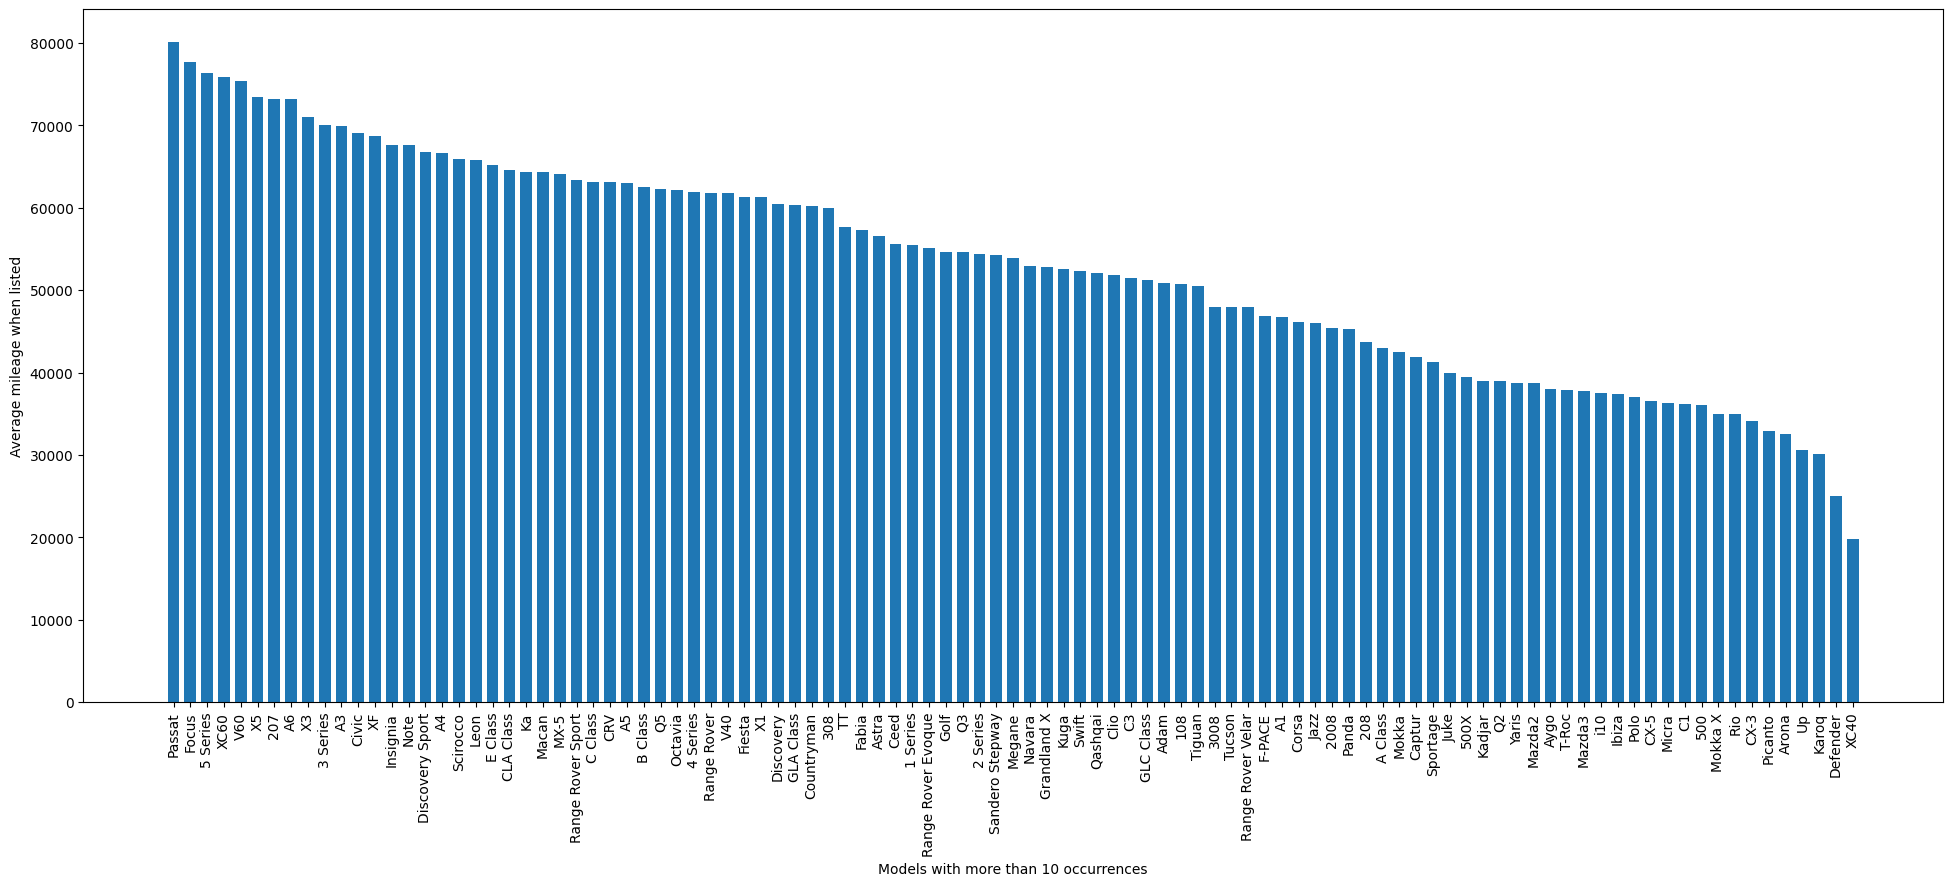

In [44]:
# investigating which models are listed with the highest average mileage. 
query = """
SELECT m.model_name,
       count(*) as occurrences,
       ROUND(avg(d.`mileage (miles)`)) AS Average, MAX(d.`mileage (miles)`) AS Max
	FROM webscraper.dataset d
			INNER JOIN models m ON m.model_id = d.model_id
group by d.model_id
HAVING occurrences > 10
ORDER BY avg(d.`mileage (miles)`) DESC
"""

results = pd.read_sql(query, mydb)

x = results['model_name']
y = results['Average']

plt.figure(figsize=(24, 9))
plt.bar(x, y, width=0.7)
plt.xlabel('Models with more than 10 occurrences'), plt.ylabel('Average mileage when listed')
plt.xticks(rotation=90)

plt.show()

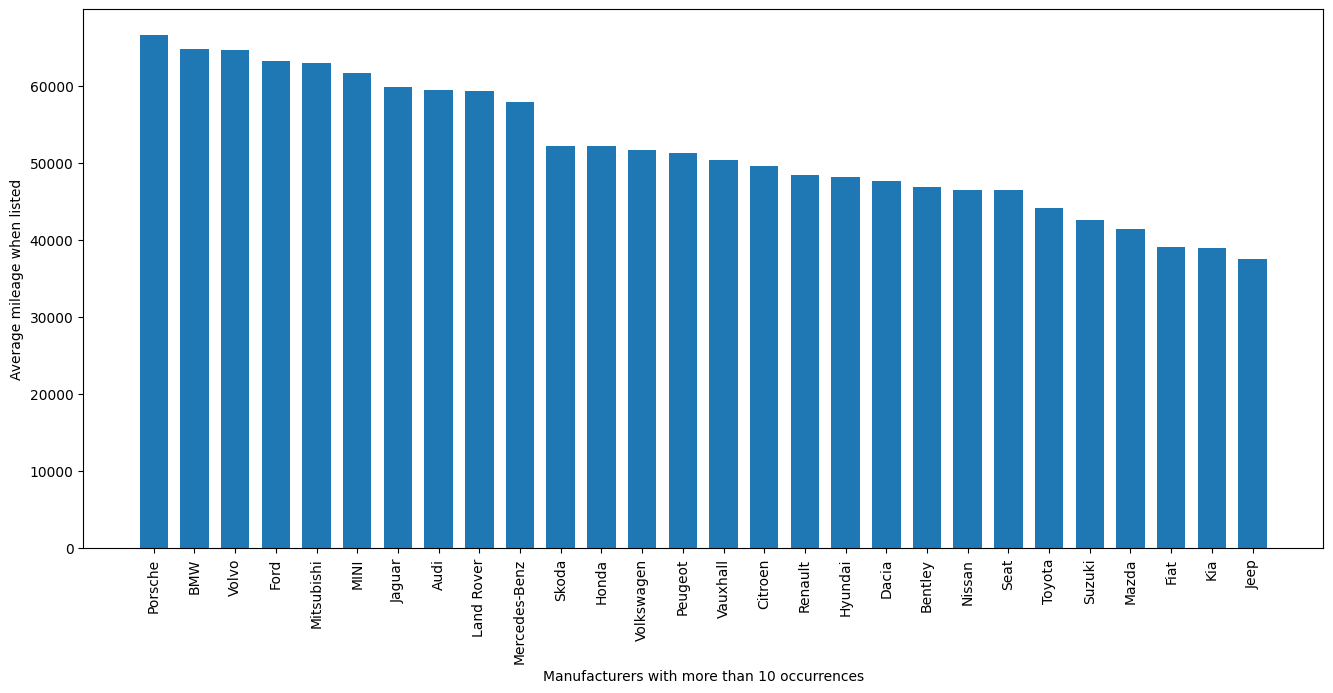

In [45]:
# similarly with manufacturers:

query = """
SELECT m.manufacturer_name,
		count(*) as occurrences,
        ROUND(avg(d.`mileage (miles)`)) AS Average, MAX(d.`mileage (miles)`) AS Max
	FROM webscraper.dataset d
			INNER JOIN manufacturers m ON m.manufacturer_id = d.manufacturer_id
Group BY d.manufacturer_id
HAVING occurrences > 10
ORDER BY AVG(d.`mileage (miles)`) DESC;

"""

results = pd.read_sql(query, mydb)

x = results['manufacturer_name']
y = results['Average']

plt.figure(figsize=(16, 7))
plt.bar(x, y, width=0.7)
plt.xlabel('Manufacturers with more than 10 occurrences'), plt.ylabel('Average mileage when listed')
plt.xticks(rotation=90)

plt.show()


In [46]:
# looking into how colour of the car affects the price, whether theres a correlation or not.
query = "SELECT Colour, COUNT(*) as occurrences FROM dataset GROUP BY Colour HAVING occurrences > 10 ORDER BY occurrences DESC;"
results = pd.read_sql(query, mydb)
print(results)

    Colour  occurrences
0    Black          941
1    White          698
2     Grey          653
3     Blue          579
4   Silver          522
5      Red          478
6    Green           27
7   Orange           26
8    Brown           23
9   Yellow           20
10   Beige           20
11   Other           13
12  Purple           12
13    Gold           12
